In [249]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy
import cvxopt
from numpy import identity
from cvxopt import matrix, solvers

datapoints = 50
lineconstants = [1, 0]
outlierproportion = 0.05
error_measure = True
C = 0.3

def kernel(x1, x2):
    return np.dot(x1, x2)

#generates linearly separable data
def generate_Data():
    Data = []
    Yi = []

    for i in range(datapoints):
        Data.append([np.random.uniform(0,1), np.random.uniform(0,1)])

    for point in Data:
        if point[0]*lineconstants[0] + lineconstants[1] - point[1] > 0:
            Yi.append(1)
        else:
            Yi.append(-1)

    for i in range(int(outlierproportion * datapoints)):
        q = np.random.randint(datapoints)
        Yi[q] = -Yi[q]
        
    return Data, Yi
        
#will plot the data on a 1x1 scatter
def plot(Data, Yi):
    for i in range(len(Data)):
        if Yi[i] == 1:
            colour = 'r'
        else:
            colour = 'b'
        plt.scatter(Data[i][0], Data[i][1], color = colour)
        
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])

    
#once you have the gradient, this will find the line position with largest 1/norm(W)
def linepos(Data, Yi, W, C, alpha):
      
    Datas = copy.deepcopy(Data)
    Wc = copy.deepcopy(W)
    dimension = len(W)
    Yii = copy.deepcopy(Yi)
    
    popthese = []
    for i in range(len(alpha)):
        if alpha[i] >= 0.95 * C:
             popthese.append(i)
    
    for i in sorted(popthese, reverse = True):
        Datas.pop(i)
        Yii.pop(i)
    
    Wc = np.array(Wc)
    Wc = Wc/np.linalg.norm(Wc)
    Datas = list(Datas)
    
    for i in range(len(Datas)):
        Datas[i] = list(Datas[i])
        D = np.array(Datas[i])
        wcomponent = np.dot(D, Wc)
        Datas[i].append(wcomponent)
        Datas[i].append(Yii[i])
        
    datapos = np.array([x for x in Datas if x[dimension + 1] == 1])
    dataneg = np.array([x for x in Datas if x[dimension + 1] == -1])

    posmax = max(datapos[:,dimension])
    posmin = min(datapos[:,dimension])
    negmax = max(dataneg[:,dimension])
    negmin = min(dataneg[:,dimension])
    
    ind1 = list(datapos[:,dimension]).index(posmax)
    ind2 = list(datapos[:,dimension]).index(posmin)
    ind3 = list(dataneg[:,dimension]).index(negmax)
    ind4 = list(dataneg[:,dimension]).index(negmin)
    
    
    if posmax >= posmin >= negmax >= negmin:
        diff = datapos[ind2][dimension] - dataneg[ind3][dimension]
        ind2array = []
        ind3array = []
        for i in range(dimension):
            ind2array.append(datapos[ind2][i])
            ind3array.append(dataneg[ind3][i])
        pointonline = (1/2) * (np.array(ind2array) + np.array(ind3array))
        b = - np.dot(Wc, pointonline)
        
        return diff, Wc, b
    
    elif negmax >= negmin >= posmax >= posmin:
        diff = dataneg[ind4][dimension] - datapos[ind1][dimension]
        ind1array = []
        ind4array = []
        for i in range(dimension):
            ind1array.append(datapos[ind1][i])
            ind4array.append(dataneg[ind4][i])
        pointonline = (1/2) * (np.array(ind1array) + np.array(ind4array))
        b = - np.dot(Wc, pointonline)
        
        return diff, Wc, b
    
    else:
        return "DOESN'T WORK"
    
#prepares inputs for the quadratic programming problem
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = np.array(P)
    P = .5 * (P + P.T)
    args = [matrix(P), matrix(q)]
    if G is not None:
        args.extend([matrix(G), matrix(h)])
        if A is not None:
            args.extend([matrix(A), matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((P.shape[1],))

#the main function. Finds the best W by quadratic programming and plots it, using the above function to find b
def findline(X, Y, C):
    vlength = len(Y)
    
    Q = []
    for i in range(len(X)):
        Q.append([])
        for j in range(len(X)):
            xn = np.array(X[i])
            xm = np.array(X[j])
            xs = kernel(xn, xm)
            ys = Y[i]*Y[j]
            element = ys*xs
            Q[i].append(element)
    
    Y = np.array(Y).astype('d')
    P = np.array(Q)
    G =  - identity(vlength)
    H = identity(vlength)
    G = list(G)
    H = list(H)
    for i in range(len(H)):
        G.append(H[i])
        
    G = np.array(G)
    h = np.zeros(2 * vlength)
    for i in range(vlength):
        h[vlength + i] = C
    b = np.array([0]).astype('d')
    q = -np.ones(vlength)
    A = matrix(Y).T
    
    alpha = cvxopt_solve_qp(Q, q, G, h, A, b)
    
    W = np.zeros(len(X[0]))
    for i in range(len(X)):
        X[i] = np.array(X[i])
        W += alpha[i]*Y[i]*X[i]
        
    line = linepos(X, Yi, W, C, alpha)
    b = line[2]
    
    W = W/np.linalg.norm(W)
    W = np.array(W)
        
    def f(x):
        result = ( -np.divide(W[0],W[1]) * x) - np.divide(b,W[1])
        return result
        
    t2 = np.arange(0.0, 1.02, 0.02)

    plt.figure(1)
    plt.plot(211)
    plt.plot (t2, f(t2), 'black')
    plot(Data, Yi)
    
        
    plt.axis([0,1,0,1])
    plt.show()
    
    return line

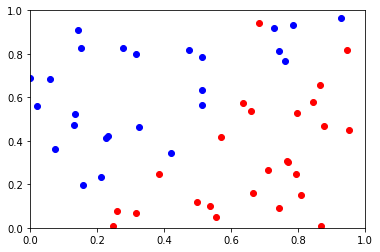

In [247]:
Data, Yi = generate_Data()
plot(Data, Yi)

     pcost       dcost       gap    pres   dres
 0: -1.5814e+01 -3.2602e+01  3e+02  8e+00  6e-16
 1: -8.0668e+00 -2.8397e+01  2e+01  9e-16  5e-16
 2: -9.0761e+00 -1.1409e+01  2e+00  2e-16  5e-16
 3: -9.9584e+00 -1.0615e+01  7e-01  2e-16  4e-16
 4: -1.0221e+01 -1.0377e+01  2e-01  2e-16  4e-16
 5: -1.0289e+01 -1.0302e+01  1e-02  3e-16  4e-16
 6: -1.0295e+01 -1.0296e+01  4e-04  3e-16  4e-16
 7: -1.0296e+01 -1.0296e+01  1e-05  4e-16  3e-16
 8: -1.0296e+01 -1.0296e+01  2e-07  8e-16  4e-16
Optimal solution found.


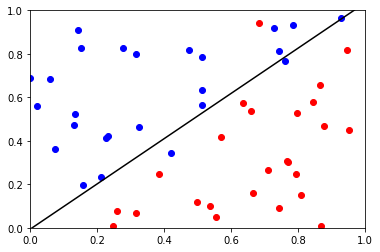

(0.9341021624929198, array([ 0.72096457, -0.69297193]), -0.004588347526390091)

In [248]:
findline(Data, Yi, C)